In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(10)
import networkx as nx
import math
from numpy import linalg as LA
from itertools import permutations

In [10]:
def positiveMatrix(X):
  result = np.where(X<0, 0, X)
  return result

In [11]:
# Generate MaxWeight service matrix for the given nxn queue switch matrix
def generateMaxWeightServiceMatrix(n, q):
  bipartite_graph = nx.complete_bipartite_graph(n,n)
  s = np.zeros((n,n))
  for e,(u,v) in enumerate(bipartite_graph.edges()):
    bipartite_graph[u][v]['weight'] = q[u][v-n]

  max_weight_match = nx.max_weight_matching(bipartite_graph,maxcardinality=True)
	
  for e,(u,v) in enumerate(max_weight_match):
    s[u][v-n] = 1
  return s

In [12]:
# Given size of the switch n, design a permutation matrix
def generateRandomServiceMatrix(n):
  num_arr = np.arange(n)
  perm_mat = np.zeros((n, n))
  for i in range(n):
    t = np.random.choice(num_arr, 1)[0]
    num_arr = np.delete(num_arr, np.where(num_arr == t))
    perm_mat[i][t] = 1
  return perm_mat

In [13]:
def chooseEpsilonGreedyServiceConfiguration(n, Q, q, epsilon):
  if np.random.uniform() < epsilon: # when we need to use the greedy policy with respect to Q
    ind = qToList(q)
    Q_value_vector = Q[tuple(ind)]
    res = np.argmax(Q_value_vector)
    return indexToService(n, res)
  else: # when we need to use the random policy
    return generateRandomServiceMatrix(n)

def chooseRandomMaxWeightServiceConfiguration(n, q, epsilon):
  if np.random.uniform() < epsilon: # when we need to use the greedy policy with respect to Q
    return generateMaxWeightServiceMatrix(n, q)
  else: # when we need to use the random policy
    return generateRandomServiceMatrix(n)

# Given queue configuration to list
def qToList(q):
  q = q.astype(int)
  q = q.flatten()
  q = q.tolist();
  return q

def possibleServiceConfigs(n):
  a = ""
  for i in range(n):
    a += str(i)
  p = permutations(a) 

  service_array = []
  for i in p:
    t = ''.join(i)
    service_array.append(t)
  return service_array

# Find the index correlating to the action
def serviceToIndex(n, s):
  service_array = possibleServiceConfigs(n)
  service_index=""
  for i in range(n):
    t = np.where(s[i]==1)[0][0]
    service_index += str(t)
  return service_array.index(service_index)

def indexToService(n, ind):
  service_array = possibleServiceConfigs(n)
  t = service_array[ind]
  s = np.zeros((n, n))
  r = 0
  for i in t:
    s[r, int(i)] = 1
    r += 1
  return s

In [14]:
# No of iterations of training
train_eps = 13000000
test_eps = 10000000
# Random variables required for algo
l = 5
# Size of the switch
n = 3
# Threshold for L2 Norm
c = 10
# Threshold for Q Table size
c1 = (int)(c/2)
# Arrival rate matrix
a_rate = np.ones((n,n))*0.99*(1/n)

## RVI Q Learning

In [15]:
def RVIQLearning(alpha, train_eps, test_eps):
  random.seed(10)
  # Q Table
  action_space = math.factorial(n)
  state_space = [c1+1]*n*n
  state_space.append(action_space)
  Q = np.zeros(state_space)
  # Queue size of switch
  q_switch_matrix = np.zeros((n, n))
  # Start training the Differential Q learning + MaxWeight algo
  service_config = np.zeros((n,n))
  Q_table_sum = 0

  for k in range(1, train_eps+1):
    s = np.zeros((n,n))
    # Choose Random policy if weight within L2 norm threshold
    if LA.norm(q_switch_matrix, 'fro') <= c: #c1 = 10
      service_config = generateRandomServiceMatrix(n)
    # Choose MaxWeight Policy otherwise
    else:
      service_config = generateMaxWeightServiceMatrix(n, q_switch_matrix)
    # Generate the arrival matrix
    arrival_matrix = np.random.poisson(a_rate)
    # compute current reward r
    r = np.sum(q_switch_matrix) 
    q_ = q_switch_matrix
    q_switch_matrix = positiveMatrix(q_switch_matrix + arrival_matrix - service_config)
    # Updating Q table for all q_switch_matrix less than threshold
    if np.max(q_) <= c1:
      # Convert the service config to index to obtain Q value
      ind = serviceToIndex(n, service_config)
      q_index = qToList(q_)
      tup_q_i = tuple(q_index)
      Q_value_vector = Q[tup_q_i]
      q_index.append(ind)
      q_index = tuple(q_index)
      # update action-value estimate Q(q(t - 1), s(t - 1)) based on Q(q(t - 1), s(t - 1)), Q(q(t), .), t, r(t - 1), and m(t - 1)
      Q[q_index] += alpha * (r + min(Q_value_vector) - Q_table_sum*(1/(2*(c1+1)**3)) - Q[q_index])
      # keep updating the sum of elements of the Q Table in Q_table_sum
      Q_table_sum += Q[q_index]

  # Testing starts from the last q_switch_matrix of the training phase
  avg_reward = 0
  for k in range(1, test_eps+1):
    # compute current reward r(t - 1)
    r = np.sum(q_switch_matrix) 
    # compute past average reward m(t) based on t and r
    avg_reward = (1 - 1 / k) * avg_reward  + 1 / k * r
    # Choose service_config based on current q_switch_matrix through Q Table if maxlength is lesser than threshold
    if np.max(q_switch_matrix) <= c1:
      q_index = qToList(q_switch_matrix)
      tup_q_i = tuple(q_index)
      Q_value_vector = Q[tup_q_i]
      # Choose vector which gives the highest reward
      ind = np.argmax(Q_value_vector)
      service_config = indexToService(n, ind)
    else:
      service_config = generateMaxWeightServiceMatrix(n, q_switch_matrix)
    arrival_matrix = np.random.poisson(a_rate)
    q_switch_matrix = positiveMatrix(q_switch_matrix + arrival_matrix - service_config)
  print("Average queue length:", avg_reward, "for alpha:",  alpha)
  return avg_reward


In [ ]:
alpha = np.array([0.001, 0.005, 0.007, 0.008, 0.009, 0.01, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

avg_total_q = np.zeros(len(alpha))
for i in range(len(alpha)):
    avg_total_q[i] = RVIQLearning(alpha[i], train_eps, test_eps)

plt.plot(alpha, avg_total_q)
plt.xlabel('Alpha')
plt.ylabel('Average Total Queue Length')
plt.title('RVI Q-learning numOfIterations = %d' %train_eps)
plt.grid()
plt.show()

Average queue length: 238.62680259999019 for alpha: 0.001
Average queue length: 251.607431600009 for alpha: 0.005
Average queue length: 254.50907799997117 for alpha: 0.007
Average queue length: 232.16971869998343 for alpha: 0.008
Average queue length: 247.5143236000035 for alpha: 0.009
Average queue length: 239.2054648999599 for alpha: 0.01
Average queue length: 253.13876240000693 for alpha: 0.1
Average queue length: 239.09736820003837 for alpha: 0.15
Average queue length: 251.36190989997306 for alpha: 0.2
Average queue length: 250.6080220999547 for alpha: 0.3


In [16]:
alpha = np.array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

avg_total_q = np.zeros(len(alpha))
for i in range(len(alpha)):
    avg_total_q[i] = RVIQLearning(alpha[i], train_eps, test_eps)

Average queue length: 243.9524076999803 for alpha: 0.4
Average queue length: 235.55589899999646 for alpha: 0.5
Average queue length: 248.78329830000627 for alpha: 0.6
Average queue length: 263.6237037999803 for alpha: 0.7
Average queue length: 244.634709999968 for alpha: 0.8
Average queue length: 243.92713119997484 for alpha: 0.9


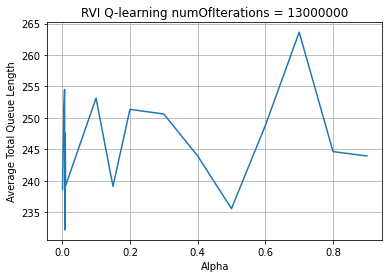

In [17]:
alpha = np.array([0.001, 0.005, 0.007, 0.008, 0.009, 0.01, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
avg_total_q = [238.62680259999019, 251.607431600009, 254.50907799997117, 232.16971869998343, 247.5143236000035, 
               239.2054648999599, 253.13876240000693, 239.09736820003837, 251.36190989997306, 250.6080220999547,
               243.9524076999803, 235.55589899999646, 248.78329830000627, 263.6237037999803, 244.634709999968,
               243.92713119997484]
plt.plot(alpha, avg_total_q)
plt.xlabel('Alpha')
plt.ylabel('Average Total Queue Length')
plt.title('RVI Q-learning numOfIterations = %d' %train_eps)
plt.grid()
plt.show()